In [1]:
import numpy as np
from gym import spaces
from recsim import document
from recsim import user
from recsim.choice_model import AbstractChoiceModel
import numpy as np
import pandas as pd
from base.wolpertinger import Wolpertinger
from base.ddpg import GaussNoise
from agent import WolpertingerRecSim, OptimalAgent
from recsim.simulator import recsim_gym, environment
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.grid'] = True

%matplotlib inline

In [2]:
DOC_NUM = 10
P_EXIT_ACCEPTED = 0.1
P_EXIT_NOT_ACCEPTED = 0.2

# let's define a matrix W for simulation of users' respose (based on the section 7.3 of the paper https://arxiv.org/pdf/1512.07679.pdf)
# W_ij defines the probability that a user will accept recommendation j given that he is consuming item i at the moment

W = (np.ones((DOC_NUM, DOC_NUM)) - np.eye(DOC_NUM)) * \
     np.random.uniform(0.0, 0.2, (DOC_NUM, DOC_NUM)) + \
     np.diag(np.random.uniform(0.9, 1.0, DOC_NUM))  
W = W[:, np.random.permutation(DOC_NUM)]

In [3]:
class Document(document.AbstractDocument):
    
    def __init__(self, doc_id):
        super(Document, self).__init__(doc_id)
        
    def create_observation(self):
        return (self._doc_id,)

    @staticmethod
    def observation_space():
        return spaces.Discrete(DOC_NUM)
  
    def __str__(self):
        return "Document #{}".format(self._doc_id)


class DocumentSampler(document.AbstractDocumentSampler):

    def __init__(self, doc_ctor=Document):
        super(DocumentSampler, self).__init__(doc_ctor)
        self._doc_count = 0
        
    def sample_document(self):
        doc = self._doc_ctor(self._doc_count % DOC_NUM)
        self._doc_count += 1
        return doc

In [4]:
class UserState(user.AbstractUserState):
    
    def __init__(self, user_id, current, active_session=True):
        self.user_id = user_id
        self.current = current
        self.active_session = active_session

    def create_observation(self):
        return (self.current,)

    def __str__(self):
        return "User #{}".format(self.user_id)

    @staticmethod
    def observation_space():
        return spaces.Discrete(DOC_NUM)

    def score_document(self, doc_obs):
        return W[self.current, doc_obs[0]]


class StaticUserSampler(user.AbstractUserSampler):

    def __init__(self, user_ctor=UserState):
        super(StaticUserSampler, self).__init__(user_ctor)
        self.user_count = 0

    def sample_user(self):
        self.user_count += 1
        sampled_user = self._user_ctor(self.user_count, np.random.randint(DOC_NUM))
        return sampled_user


class Response(user.AbstractResponse):

    def __init__(self, accept=False):
        self.accept = accept

    def create_observation(self):
        return (int(self.accept),)

    @classmethod
    def response_space(cls):
        return spaces.Discrete(2)


class UserChoiceModel(AbstractChoiceModel):
    def __init__(self):
        super(UserChoiceModel, self).__init__()
        self._score_no_click = P_EXIT_ACCEPTED

    def score_documents(self, user_state, doc_obs):
        if len(doc_obs) != 1:
            raise ValueError("Expecting single document, but got: {}".format(doc_obs))
        self._scores = np.array([user_state.score_document(doc) for doc in doc_obs])

    def choose_item(self):
        if np.random.random() < self.scores[0]:
            return 0


class UserModel(user.AbstractUserModel):
    def __init__(self):
        super(UserModel, self).__init__(Response, StaticUserSampler(), 1)
        self.choice_model = UserChoiceModel()

    def simulate_response(self, slate_documents):
        if len(slate_documents) != 1:
            raise ValueError("Expecting single document, but got: {}".format(slate_documents))

        responses = [self._response_model_ctor() for _ in slate_documents]

        self.choice_model.score_documents(self._user_state, [doc.create_observation() for doc in slate_documents])
        selected_index = self.choice_model.choose_item()

        if selected_index is not None:
            responses[selected_index].accept = True

        return responses

    def update_state(self, slate_documents, responses):

        if len(slate_documents) != 1:
            raise ValueError("Expecting single document, but got: {}".format(slate_documents))

        response = responses[0]
        doc = slate_documents[0]
        if response.accept:
            self._user_state.current = doc.doc_id()
            self._user_state.active_session = bool(np.random.binomial(1, 1 - P_EXIT_ACCEPTED))
        else:
            self._user_state.current = np.random.choice(DOC_NUM)
            self._user_state.active_session = bool(np.random.binomial(1, 1 - P_EXIT_NOT_ACCEPTED))

    def is_terminal(self):
        """Returns a boolean indicating if the session is over."""
        return not self._user_state.active_session


def clicked_reward(responses):
    reward = 0.0
    for response in responses:
        if response.accept:
            reward += 1
    return reward

In [5]:
env = recsim_gym.RecSimGymEnv(
    environment.Environment(UserModel(), DocumentSampler(), DOC_NUM, 1, resample_documents=False),
    clicked_reward
)

In [6]:
parameters = {'action_dim': DOC_NUM,
              'state_dim': DOC_NUM,
              'noise': GaussNoise(sigma=0.05),
              'critic_lr': 1e-3,
              'actor_lr': 1e-3,
              'soft_tau': 1e-3,
              'hidden_dim': 256,
              'batch_size': 128,
              'buffer_size': 20000,
              'gamma': 0.8,
              'actor_weight_decay': 0.0001,
              'critic_weight_decay': 0.001,
              'eps': 1e-2
              }

For solving of this toy environment we'll try using a variant of DDPG algorithm for discrete actions.
We need to embed our discrete actions into continuous space to use DDPG (it outputs "proto action").
Then we choose k nearest embedded actions and take the action with maximum Q value.
Thus, we can avoid taking maximum over all the action space as in DQN, which can be too large in case of RecSys.
In our example embeddings are just one hot vectors. Therefore the nearest neighbour is argmax of proto action.

<img src="wolpertinger_scheme.png" width=400 height=800>

In [7]:
agent = WolpertingerRecSim(env=env, action_space=env.action_space,
                               k_ratio=0.33, summary_writer=None,
                               eval_mode=False, **parameters)
# this agent is DDPG w

reward_history = []
step_number = 0
total_reward = 0.
observation = env.reset()
while step_number < 60000:
    
    action = agent.begin_episode(observation)
    episode_reward = 0
    while True:
        observation, reward, done, info = env.step(action)
        episode_reward += reward

        if step_number % 2000 == 0:
            print(episode_reward)
        step_number += 1
        if done:
            break
        else:
            action = agent.step(reward, observation)
            
    agent.end_episode(reward, observation)
    reward_history.append(episode_reward)

0.0
1.0
2.0
7.0
2.0
2.0
6.0
0.0
4.0
3.0
17.0
3.0
6.0
18.0
30.0
21.0
8.0
4.0
3.0
7.0
11.0
25.0
7.0
5.0
1.0
3.0
3.0
2.0
5.0
1.0
2.0


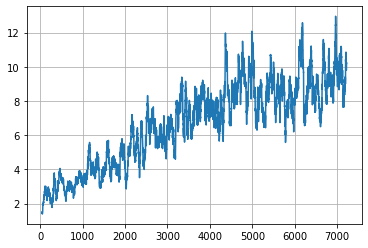

In [8]:
plt.plot(pd.Series(reward_history).rolling(50).mean())

In [9]:
q_values = np.hstack([agent.agent.compute_q_values(i) for i in range(DOC_NUM)]).T
actions = np.vstack([super(Wolpertinger, agent.agent)
                    .predict(np.eye(DOC_NUM)[i], with_noise=False)
                     for i in range(DOC_NUM)])

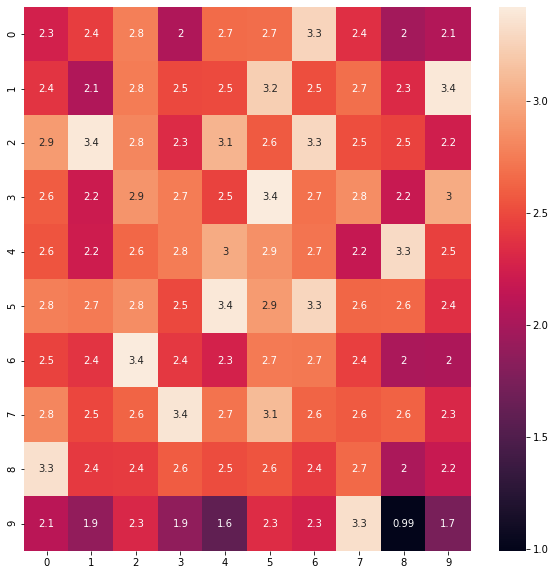

In [10]:
plt.subplots(figsize=q_values.shape)
sns.heatmap(q_values.round(3), annot=True);

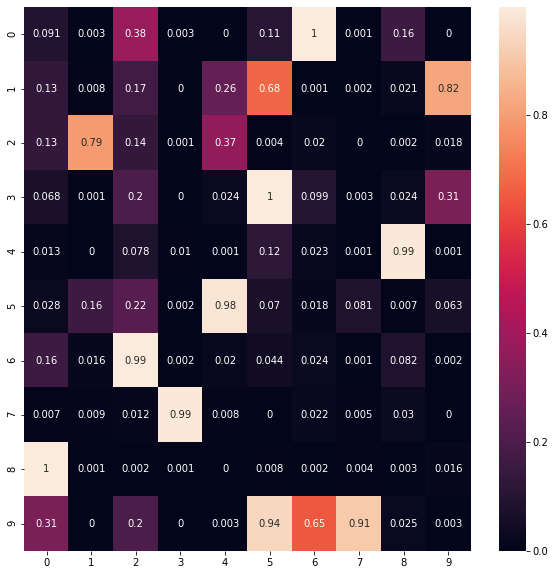

In [18]:
plt.subplots(figsize=q_values.shape)
sns.heatmap(actions.round(3), annot=True);

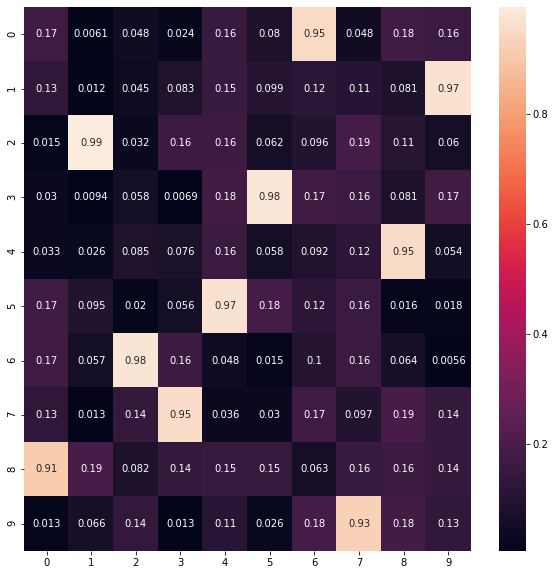

In [19]:
plt.subplots(figsize=q_values.shape)
sns.heatmap(W, annot=True);

In [13]:
optimal_agent = OptimalAgent(env, W)
reward_history = []
step_number = 0
total_reward = 0.
observation = env.reset()
while step_number < 60000:
    
    action = optimal_agent.begin_episode(observation)
    episode_reward = 0
    while True:
        observation, reward, done, info = env.step(action)
        episode_reward += reward

        if step_number % 2000 == 0:
            print(episode_reward)
        step_number += 1
        if done:
            break
        else:
            action = optimal_agent.step(reward, observation)
            
    optimal_agent.end_episode(reward, observation)
    reward_history.append(episode_reward)

1.0
24.0
1.0
20.0
6.0
15.0
9.0
9.0
2.0
25.0
7.0
13.0
2.0
3.0
2.0
25.0
7.0
33.0
1.0
18.0
3.0
14.0
7.0
17.0
13.0
9.0
16.0
5.0
18.0
14.0
9.0


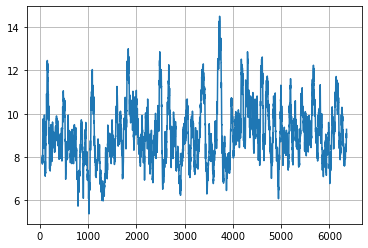

In [14]:
plt.plot(pd.Series(reward_history).rolling(50).mean())

In [15]:
from recsim.agents.tabular_q_agent import TabularQAgent

In [16]:
q_agent = TabularQAgent(env.observation_space, env.action_space)
reward_history = []
step_number = 0
total_reward = 0.
observation = env.reset()
while step_number < 60000:
    
    action = q_agent.begin_episode(observation)
    episode_reward = 0
    while True:
        observation, reward, done, info = env.step(action)
        episode_reward += reward

        if step_number % 2000 == 0:
            print(episode_reward)
        step_number += 1
        if done:
            break
        else:
            action = q_agent.step(reward, observation)
            
    optimal_agent.end_episode(reward, observation)
    reward_history.append(episode_reward)

1.0
1.0
0.0
0.0
0.0
2.0
2.0
2.0
0.0
0.0
3.0
0.0
1.0
1.0
2.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
2.0
1.0
4.0


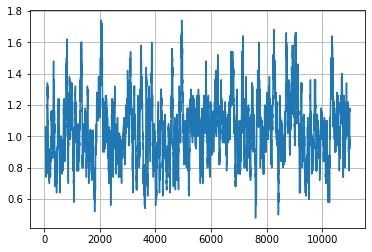

In [17]:
plt.plot(pd.Series(reward_history).rolling(50).mean())